In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torchvision 
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F
import warnings
warnings.simplefilter("ignore")

In [2]:
def load_fashion_mnist(batch_size, norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.FashionMNIST(root='../data', train=True,
                                                 download=True, transform=transform)
    print("trainset: ", trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.FashionMNIST(root='../data', train=False,
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=True)
    testset = list(iter(testloader))
    for i, (img, label) in enumerate(trainset):
        trainset[i] = (img.reshape(len(img), 784) / norm_factor, label)
    for i, (img, label) in enumerate(testset):
        testset[i] = (img.reshape(len(img), 784) / norm_factor, label)
    return trainset, testset

trainset, testset = load_fashion_mnist(1000)
imgs,labels = trainset[0]

trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7d70282908d0>


In [3]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

class ImageTransformer:
    def __init__(self):
        pass

    def binarize(self, img):
        i = deepcopy(img)
        i[img > 0] = -1
        i[img <= 0] = 1
        return i

    def mask_image(self, img, mask_type):
        i = deepcopy(img)
        H, W = img.shape
        is_binary = np.array_equal(np.unique(img), [-1, 1])

        if mask_type == 'bottom_half':
            i[H//2:H, :] = -1 if is_binary else 0
        elif mask_type == 'top_half':
            i[0:H//2, :] = -1 if is_binary else 0
        elif mask_type == 'left_half':
            i[:, 0:W//2] = -1 if is_binary else 0
        elif mask_type == 'right_half':
            i[:, W//2:W] = -1 if is_binary else 0
        elif mask_type == 'diagonal':
            for x in range(W):
                for y in range(H):
                    if x > y:
                        i[y, x] = -1 if is_binary else 0
        elif mask_type == 'anti_diagonal':
            for x in range(W):
                for y in range(H):
                    if x + y < W:
                        i[y, x] = -1 if is_binary else 0
        elif mask_type == 'diagonal_sym':
            for x in range(W):
                for y in range(H):
                    if x < y:
                        i[y, x] = -1 if is_binary else 0
        elif mask_type == 'anti_diagonal_sym':
            for x in range(W):
                for y in range(H):
                    if x + y >= W:
                        i[y, x] = -1 if is_binary else 0
        return i

    def add_noise(self, img, noise_level=0.1):
        i = deepcopy(img)
        noise = np.random.normal(0, noise_level, img.shape)
        noisy_img = np.add(i, noise)
        return noisy_img

    def add_noise_binary(self, img, noise_level=0.1):
        i = deepcopy(img)
        noise = np.random.choice([0, 1], size=img.shape, p=[1-noise_level, noise_level])
        noisy_img = np.where(noise == 1, -i, i)
        return noisy_img

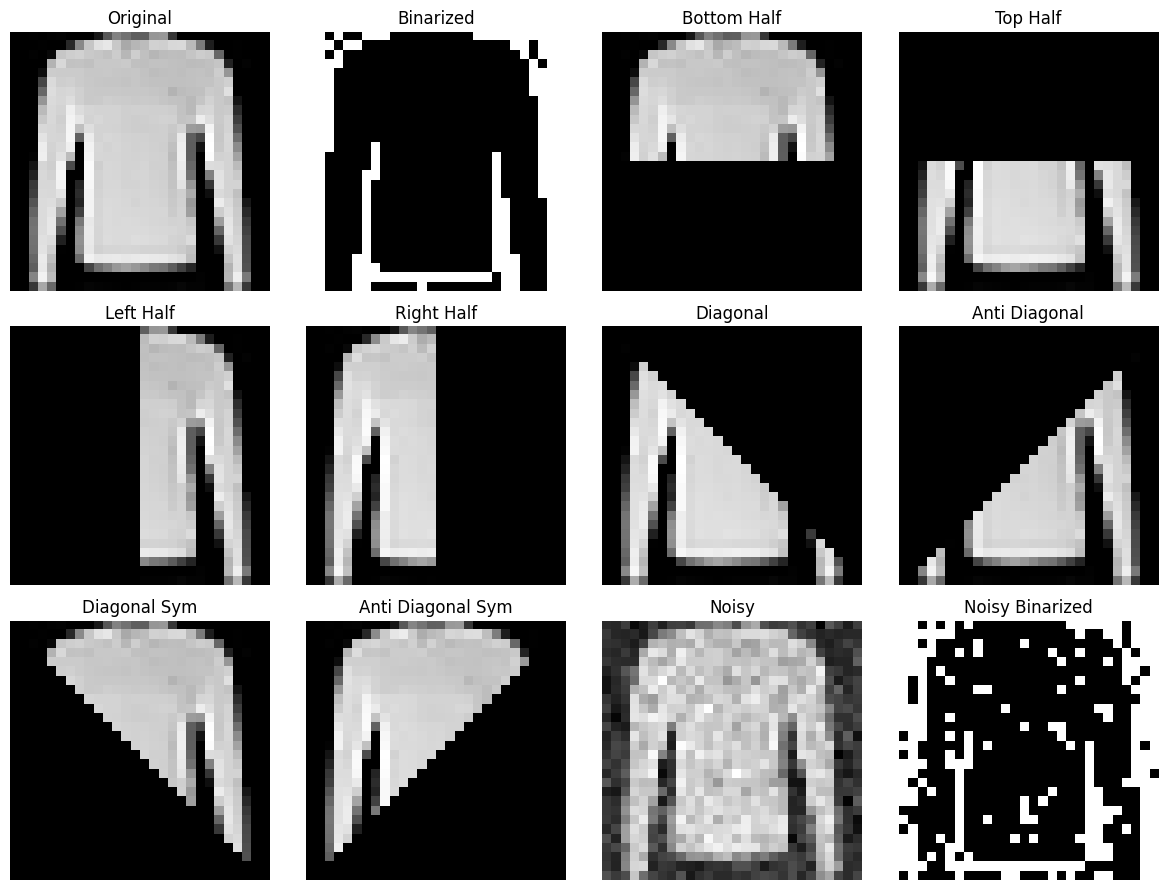

In [4]:

transformer = ImageTransformer()
img = imgs[3,:].reshape(28, 28)

binarized_img = transformer.binarize(img)
masked_imgs = {
    'bottom_half': transformer.mask_image(img, 'bottom_half'),
    'top_half': transformer.mask_image(img, 'top_half'),
    'left_half': transformer.mask_image(img, 'left_half'),
    'right_half': transformer.mask_image(img, 'right_half'),
    'diagonal': transformer.mask_image(img, 'diagonal'),
    'anti_diagonal': transformer.mask_image(img, 'anti_diagonal'),
    'diagonal_sym': transformer.mask_image(img, 'diagonal_sym'),
    'anti_diagonal_sym': transformer.mask_image(img, 'anti_diagonal_sym')
}
noisy_img = transformer.add_noise(img, noise_level=0.1)
noisy_binarized_img = transformer.add_noise_binary(binarized_img, noise_level=0.1)

# Plotting the images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(binarized_img, cmap='gray')
axes[1].set_title('Binarized')

for idx, (key, masked_img) in enumerate(masked_imgs.items(), start=2):
    axes[idx].imshow(masked_img, cmap='gray')
    axes[idx].set_title(key.replace('_', ' ').title())

axes[10].imshow(noisy_img, cmap='gray')
axes[10].set_title('Noisy')

axes[11].imshow(noisy_binarized_img, cmap='gray')
axes[11].set_title('Noisy Binarized')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy

class HopfieldNetwork:
    def __init__(self, binary=True):
        self.binary = binary

    def demircigil_update_rule(self, z, xs):
        out = torch.zeros(len(z), 1)
        z_pos = deepcopy(z)
        z_neg = deepcopy(z)
        
        for i in range(len(z)):
            E_pos, E_neg = 0, 0
            z_pos[i], z_neg[i] = 1, -1
            
            for x in xs:
                E_pos += torch.exp((x.T @ z_pos) / 10)
                E_neg += torch.exp((x.T @ z_neg) / 10)
            
            out[i] = 1 if E_pos > E_neg else -1
            
            z_pos[i], z_neg[i] = z[i], z[i]
        
        return out

    def continuous_update_rule(self, X, z, beta):
        X = X.float()
        z = z.float()
        return X.T @ F.softmax(beta * X @ z, dim=0)

    def retrieve_store(self, imgs, N, transform_func=None, beta=8, num_plot=5, break_val=-1):
        if self.binary:
            binarizer = ImageTransformer()
            xs = [binarizer.binarize(imgs[i,:].reshape(784,1)) for i in range(N)]
            for j in range(N):
                if break_val > 0 and j >= break_val:
                    break
                halved_digit = transform_func(xs[j].reshape(28,28)).reshape(784,1)
                out = self.demircigil_update_rule(halved_digit, xs)
                self.plot_images(xs[j], halved_digit, out)
        else:
            X = imgs[0:N,:]
            for j in range(N):
                if break_val > 0 and j >= break_val:
                    break
                z = transform_func(X[j,:].reshape(28,28)).reshape(784,1)
                out = self.continuous_update_rule(X,z,beta)
                self.plot_images(X[j, :].reshape(28,28), z, out)

    def plot_images(self, original, masked, reconstruction):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
        imgs = [original, masked, reconstruction]
        titles = ["Original", "Transformed", "Reconstruction"]
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(imgs[i].reshape(28, 28), cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
        plt.show()

Mask: bottom_half


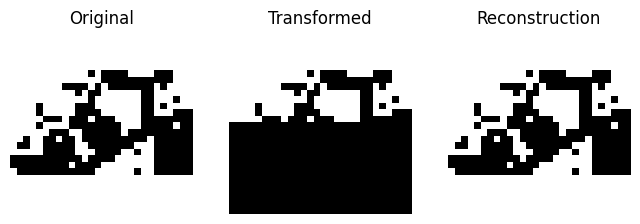

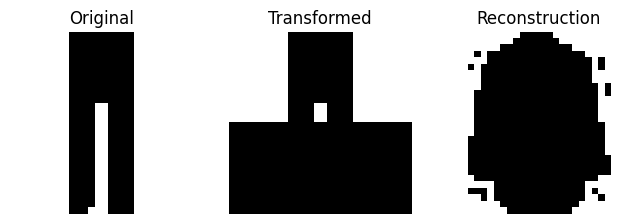

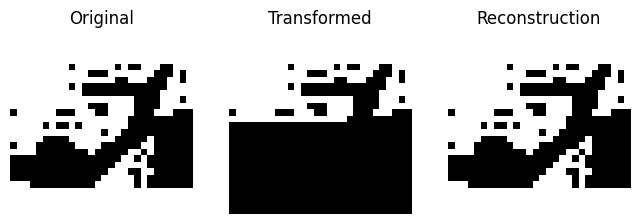

Mask: top_half


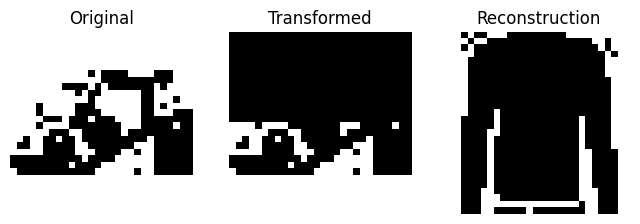

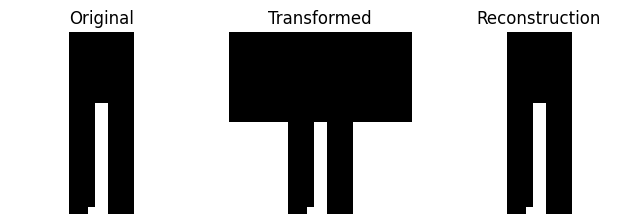

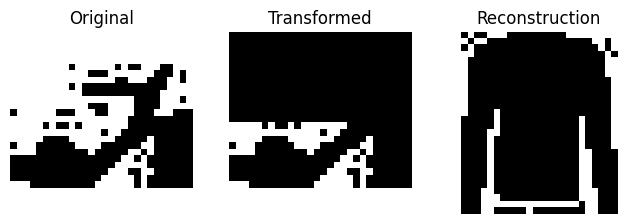

Mask: left_half


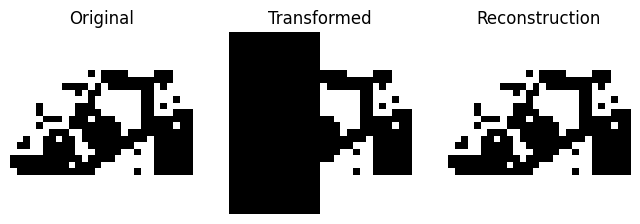

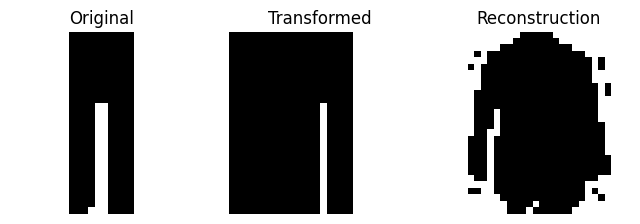

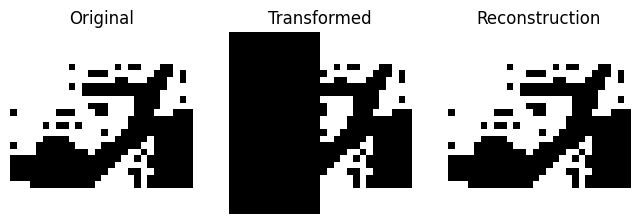

Mask: right_half


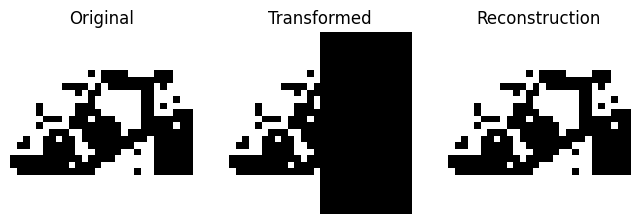

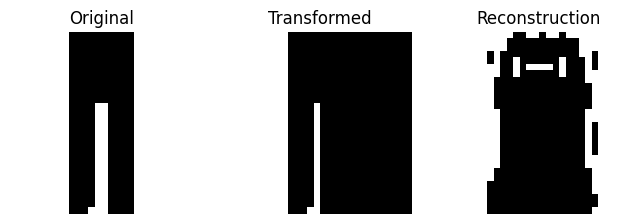

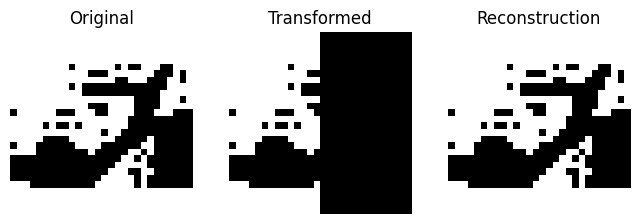

Mask: diagonal


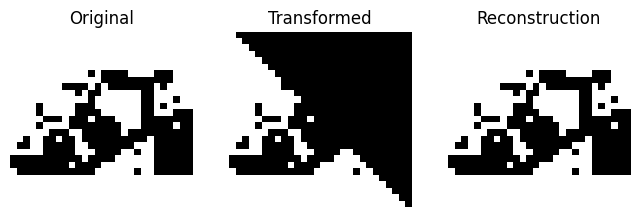

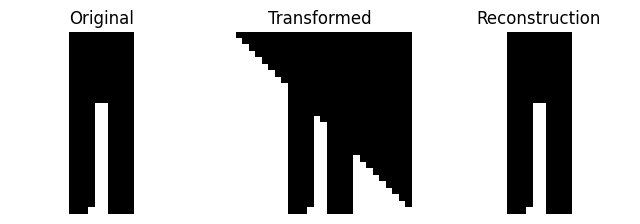

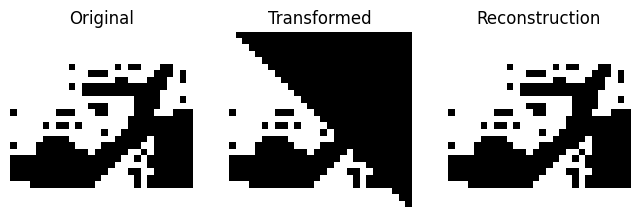

Mask: anti_diagonal


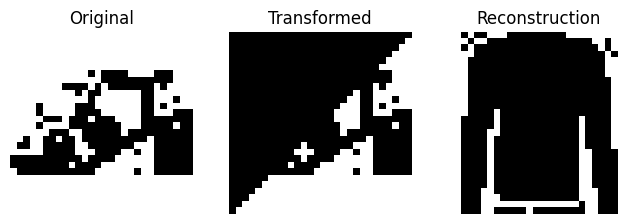

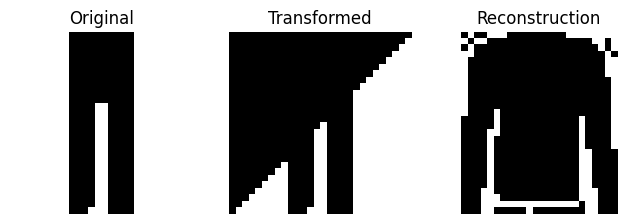

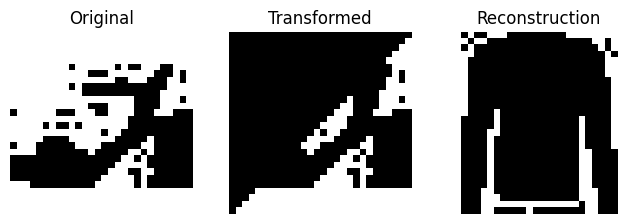

Mask: diagonal_sym


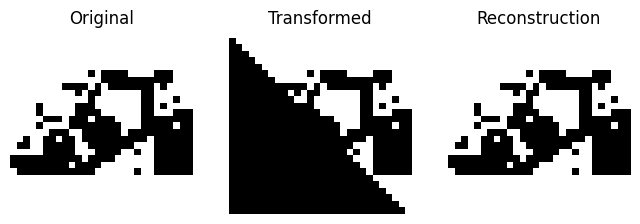

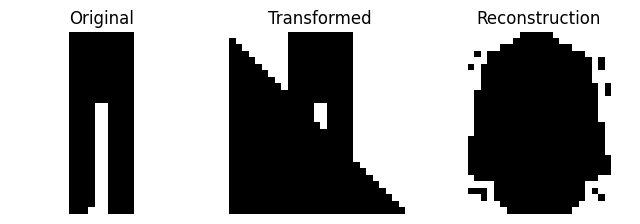

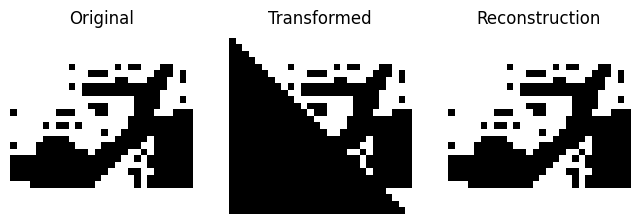

Mask: anti_diagonal_sym


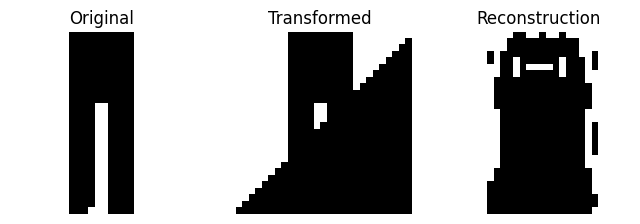

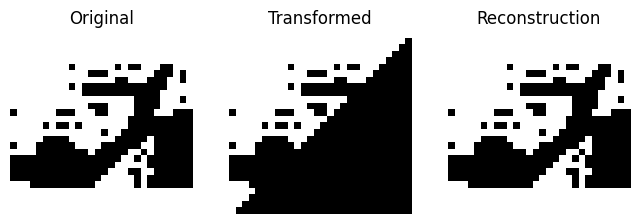

Noisy:


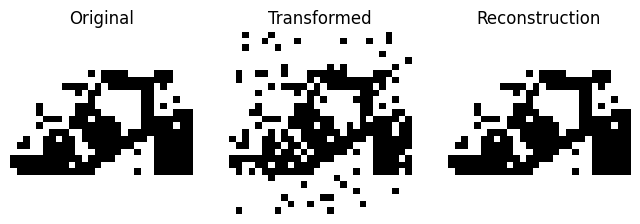

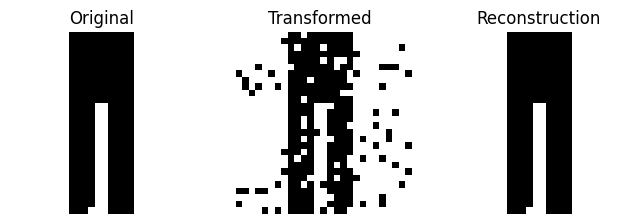

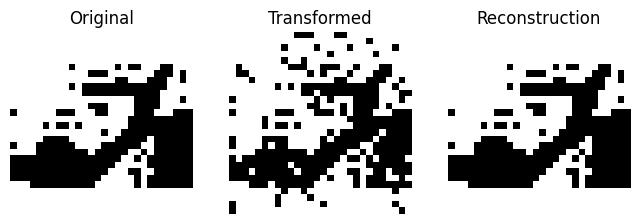

In [6]:
hopfield = HopfieldNetwork(binary=True)

masks = ['bottom_half', 'top_half', 'left_half', 'right_half', 'diagonal', 'anti_diagonal', 'diagonal_sym', 'anti_diagonal_sym']
for mask in masks:
    print(f"Mask: {mask}")
    hopfield.retrieve_store(imgs, 10, transform_func=lambda im: transformer.mask_image(im, mask_type=mask), num_plot=3, break_val=3)
print("Noisy:")
hopfield.retrieve_store(imgs, 10, transform_func=lambda im: transformer.add_noise_binary(im), num_plot=3, break_val=3)


Mask: bottom_half


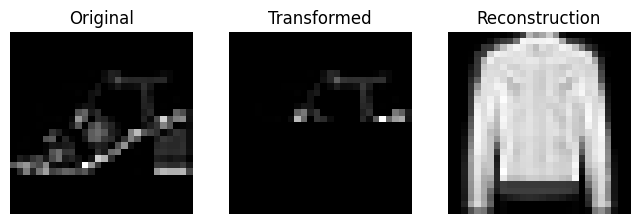

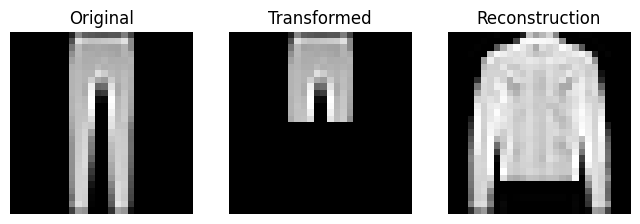

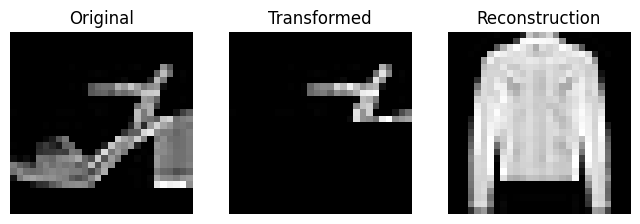

Mask: top_half


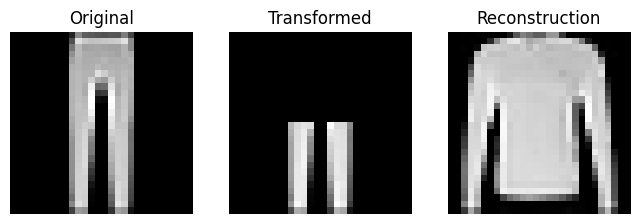

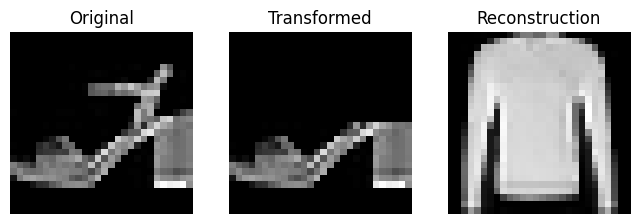

Mask: left_half


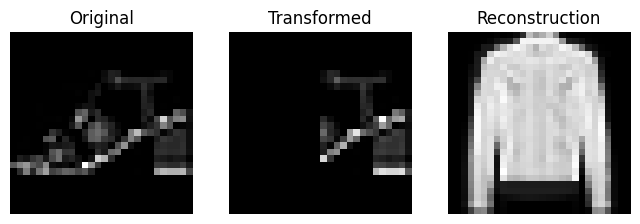

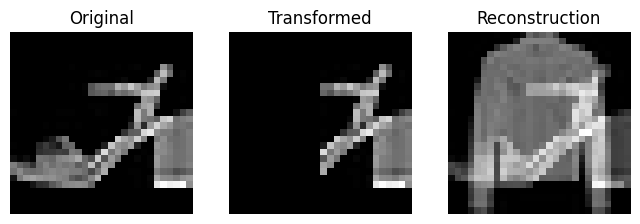

Mask: right_half


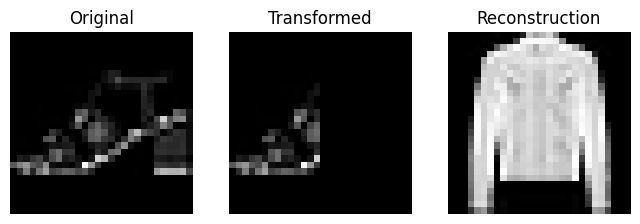

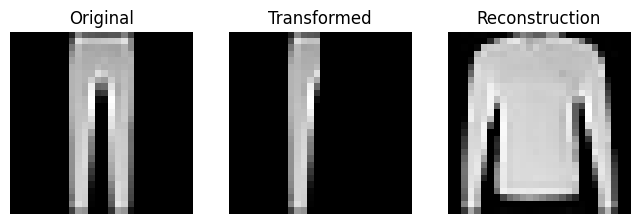

Mask: diagonal


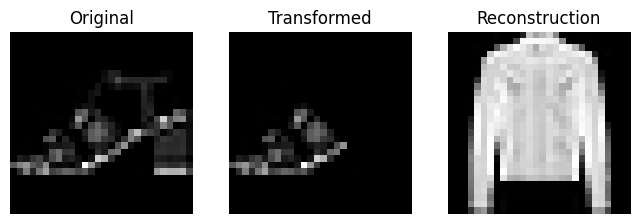

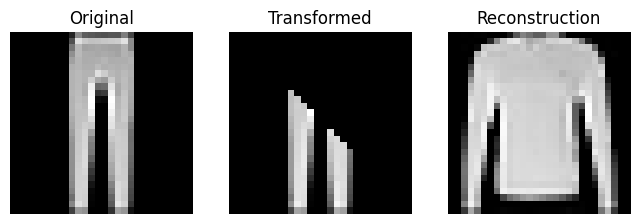

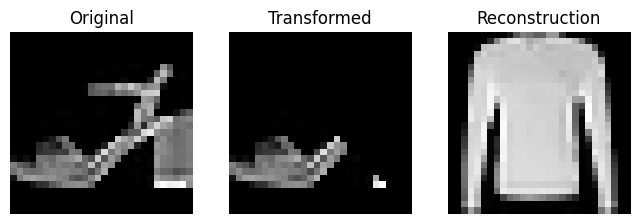

Mask: anti_diagonal


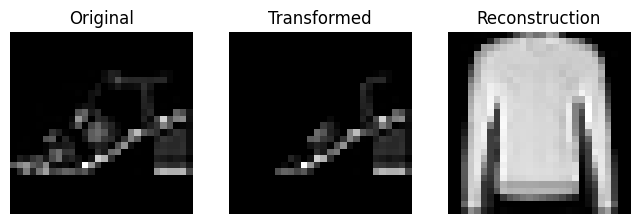

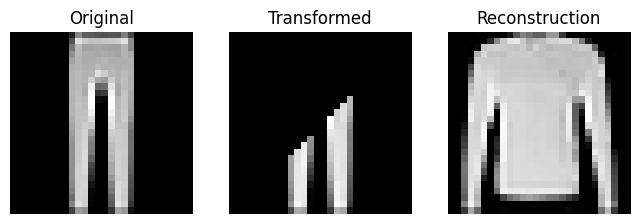

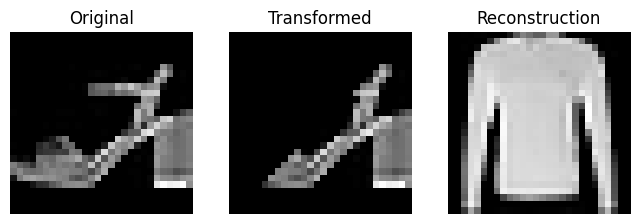

Mask: diagonal_sym


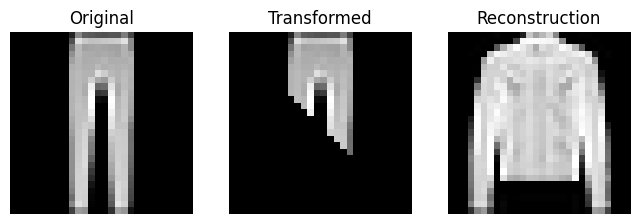

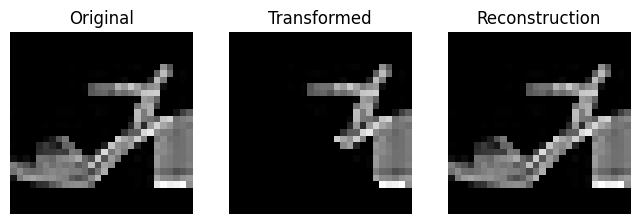

Mask: anti_diagonal_sym


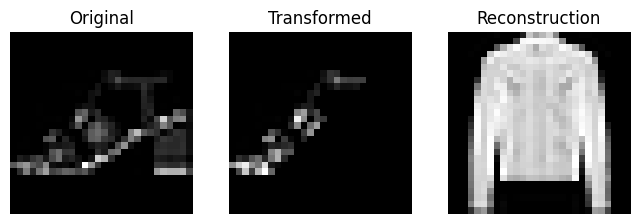

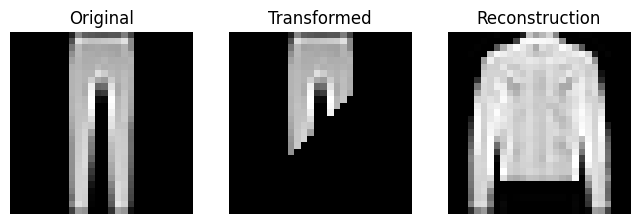

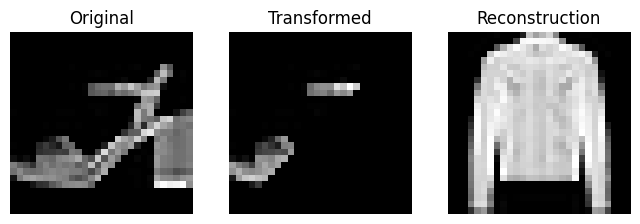

Noisy:


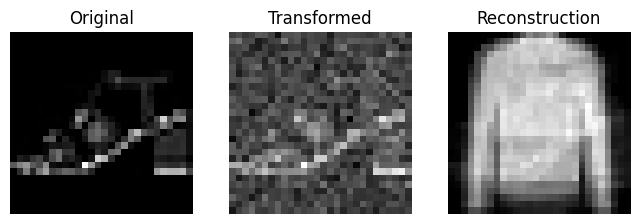

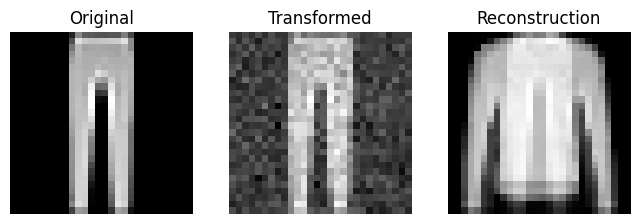

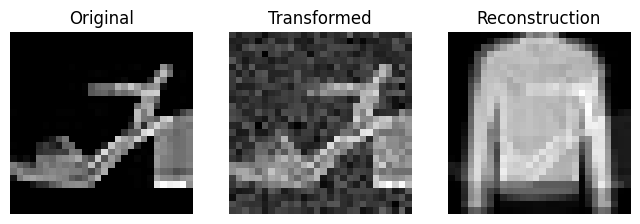

In [ ]:
hopfield = HopfieldNetwork(binary=False)

masks = ['bottom_half', 'top_half', 'left_half', 'right_half', 'diagonal', 'anti_diagonal', 'diagonal_sym', 'anti_diagonal_sym']
for mask in masks:
    print(f"Mask: {mask}")
    hopfield.retrieve_store(imgs, 10, transform_func=lambda im: transformer.mask_image(im, mask_type=mask), num_plot=3, break_val=3)
print("Noisy:")
hopfield.retrieve_store(imgs, 10, transform_func=lambda im: transformer.add_noise(im), num_plot=3, break_val=3, beta=0.1)

Number of images: 10


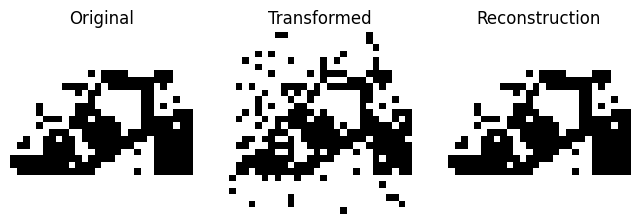

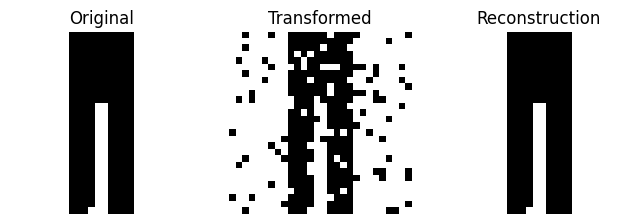

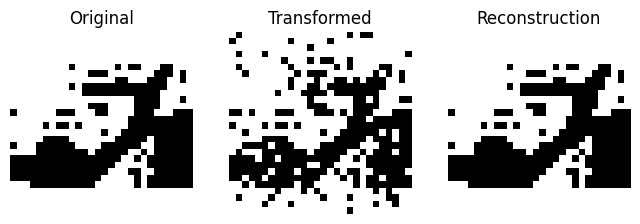

Number of images: 100


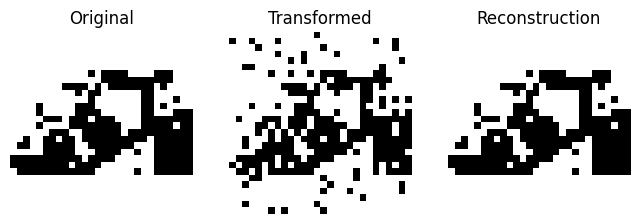

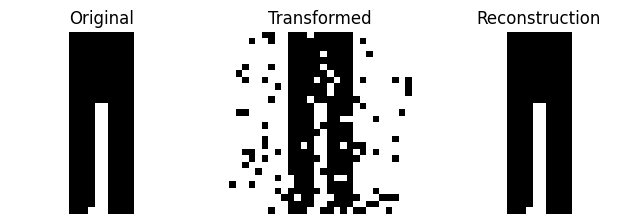

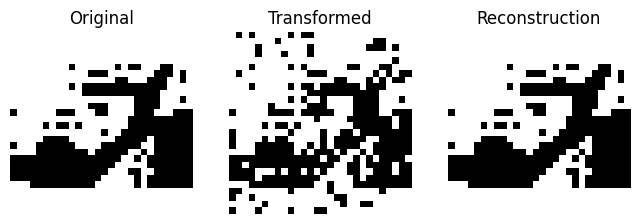

Number of images: 1000


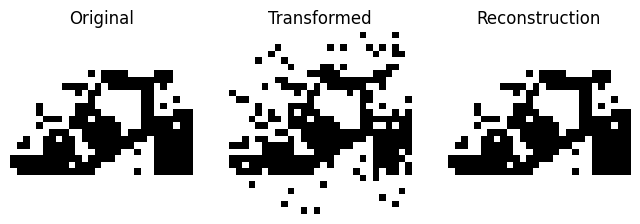

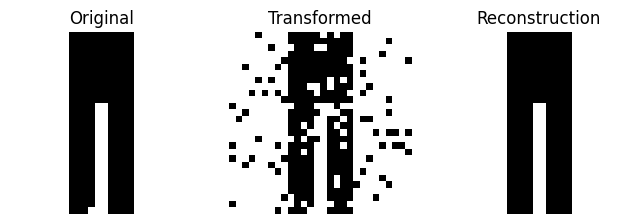

KeyboardInterrupt: 

In [9]:
hopfield = HopfieldNetwork(binary=True)

im_numbers = [10, 100, 1000, 5000, 10000]
for im_number in im_numbers:
    print(f"Number of images: {im_number}")
    hopfield.retrieve_store(imgs, im_number , transform_func=lambda im: transformer.add_noise_binary(im), num_plot=3, break_val=3)

Number of images: 10


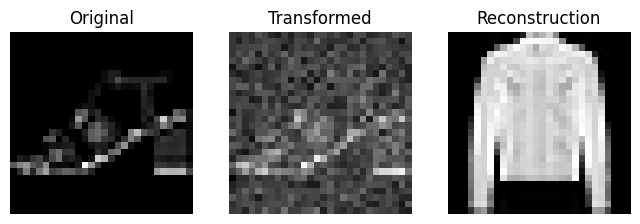

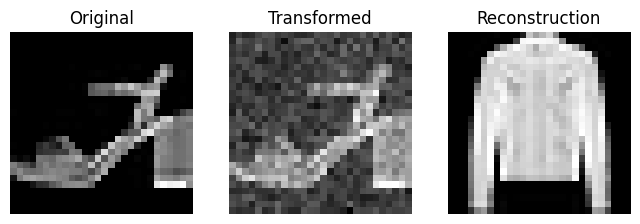

Number of images: 100


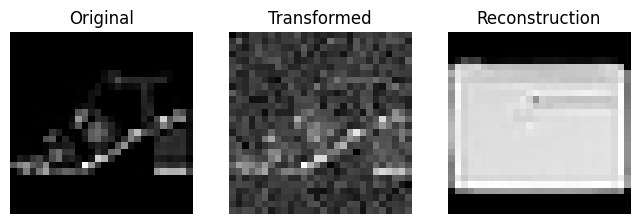

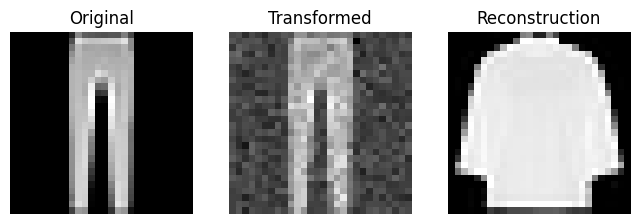

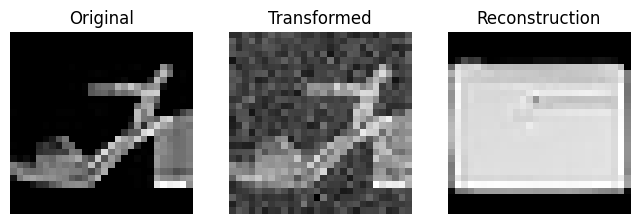

Number of images: 1000


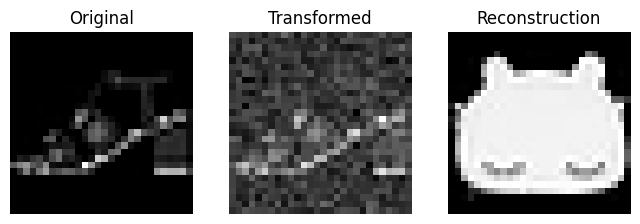

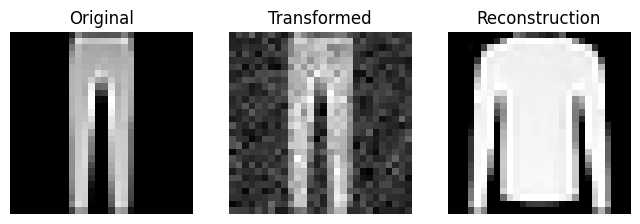

Number of images: 5000


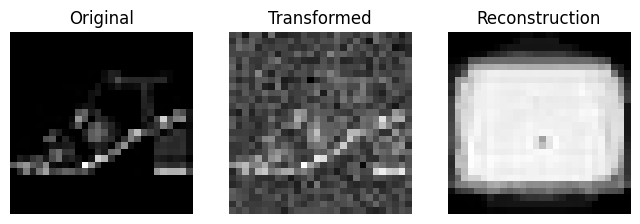

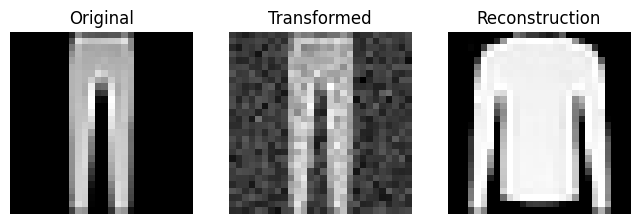

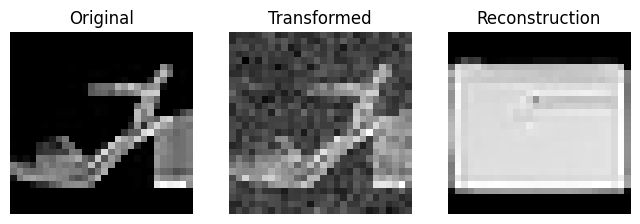

Number of images: 10000


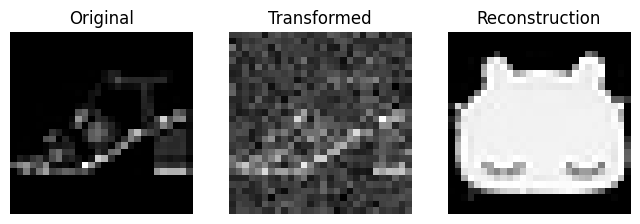

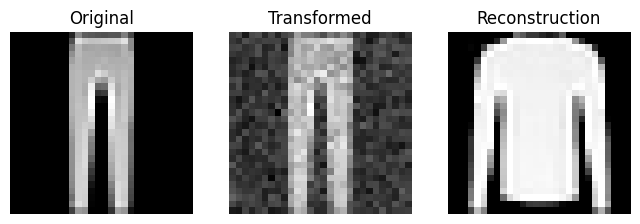

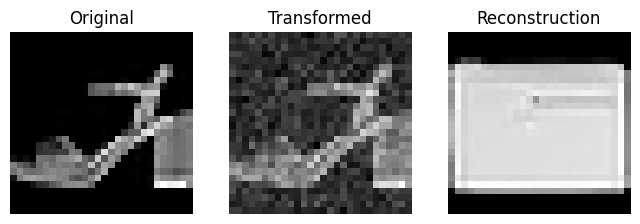

In [ ]:
hopfield = HopfieldNetwork(binary=False)

im_numbers = [10, 100, 1000, 5000, 10000]
for im_number in im_numbers:
    print(f"Number of images: {im_number}")
    hopfield.retrieve_store(imgs, im_number , transform_func=lambda im: transformer.add_noise(im), num_plot=3, break_val=3)

Noise level: 0.02


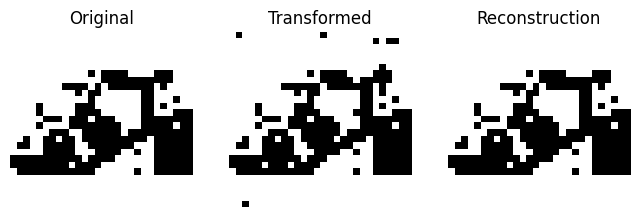

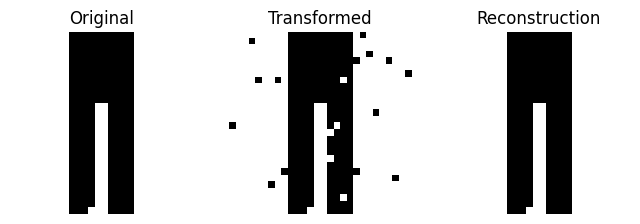

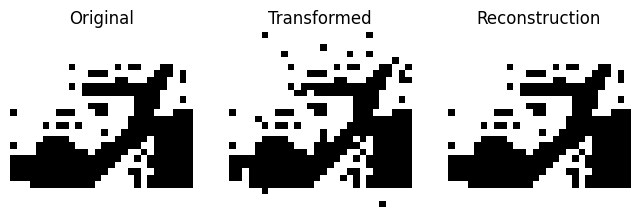

Noise level: 0.05


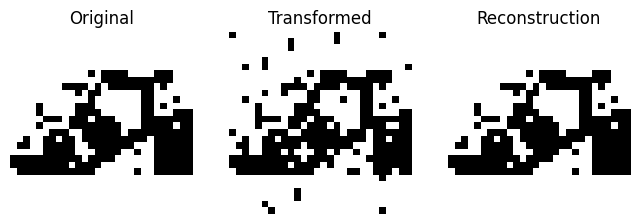

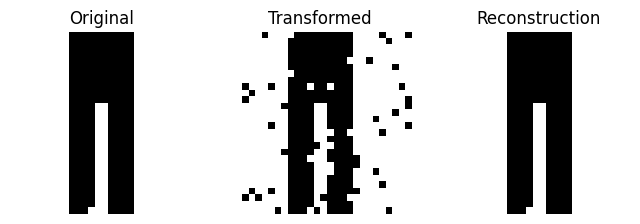

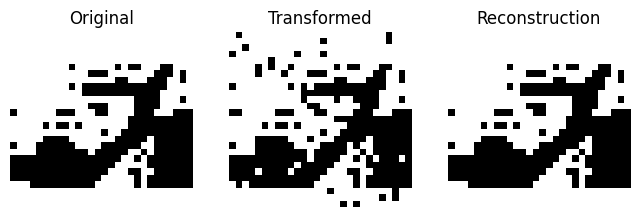

Noise level: 0.1


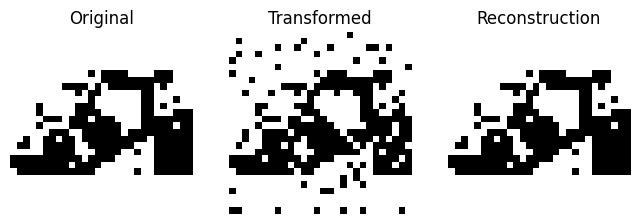

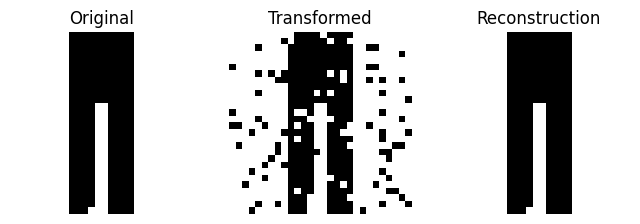

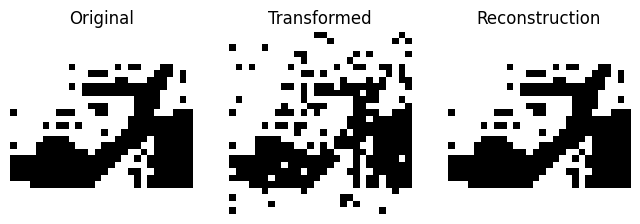

Noise level: 0.2


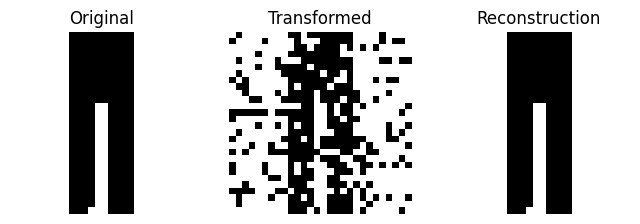

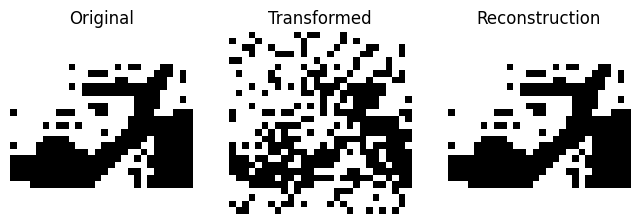

Noise level: 0.3


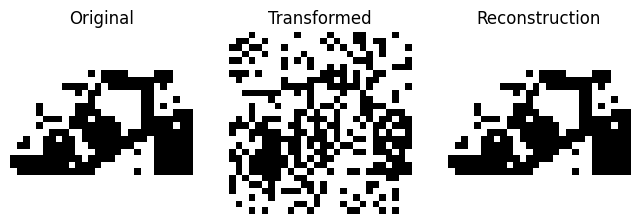

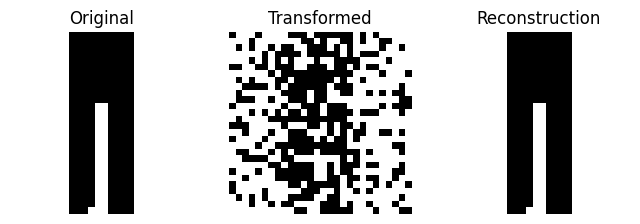

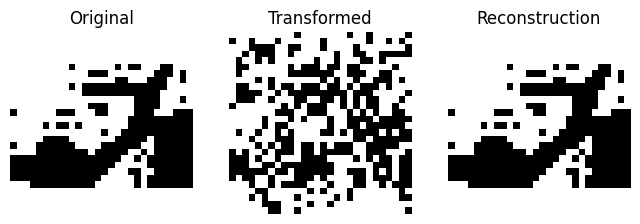

In [20]:
hopfield = HopfieldNetwork(binary=True)

noise_levels = [0.02, 0.05, 0.1, 0.2, 0.3]
for noise_level in noise_levels:
    print(f"Noise level: {noise_level}")
    hopfield.retrieve_store(imgs, 100, transform_func=lambda im: transformer.add_noise_binary(im, noise_level=noise_level), num_plot=3, break_val=3)

Noise level: 0.02


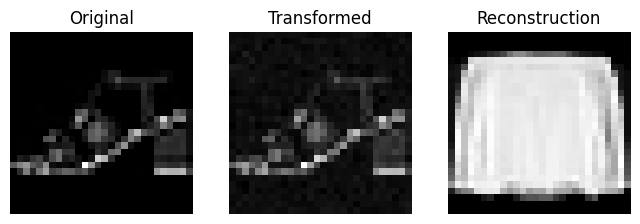

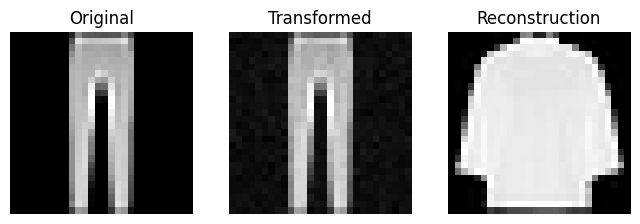

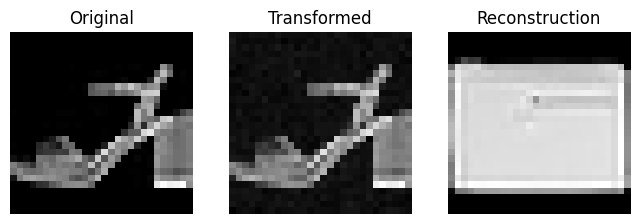

Noise level: 0.05


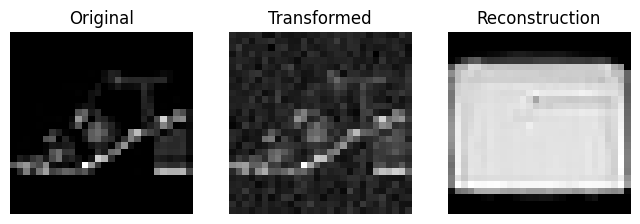

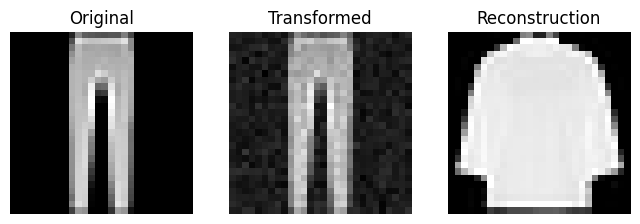

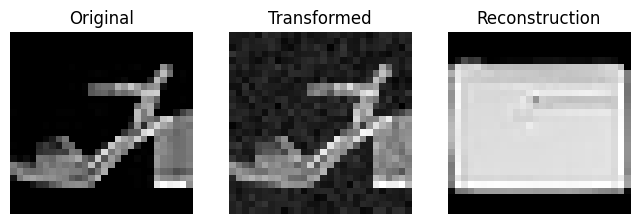

Noise level: 0.1


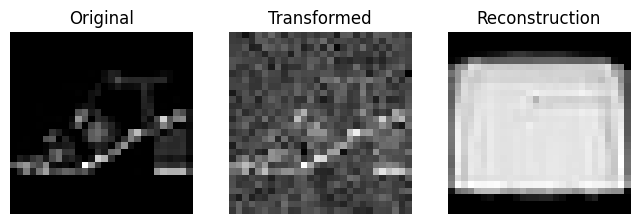

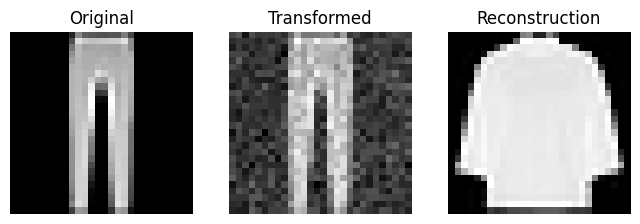

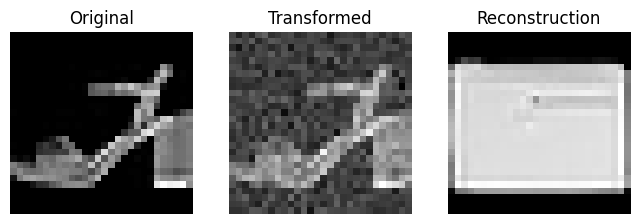

Noise level: 0.2


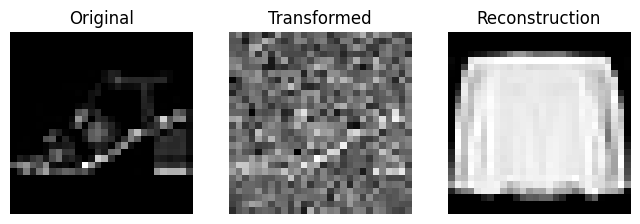

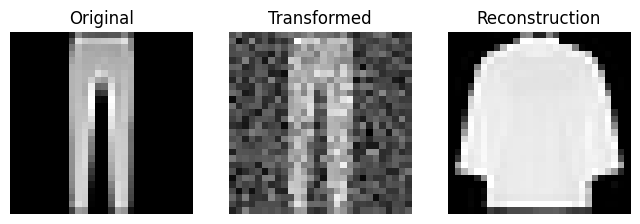

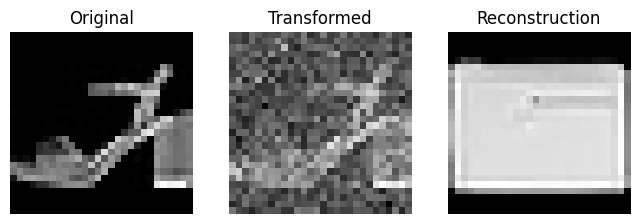

Noise level: 0.3


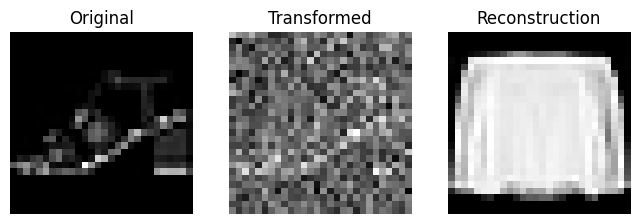

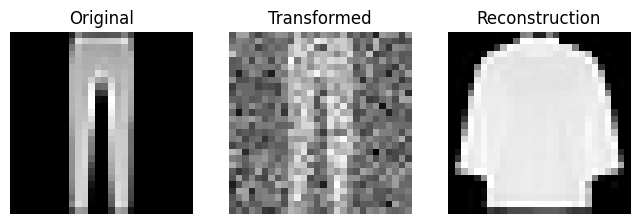

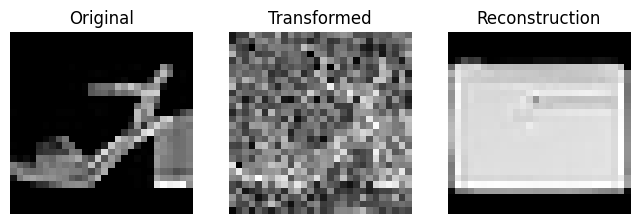

In [16]:
hopfield = HopfieldNetwork(binary=False)

noise_levels = [0.02, 0.05, 0.1, 0.2, 0.3]
for noise_level in noise_levels:
    print(f"Noise level: {noise_level}")
    hopfield.retrieve_store(imgs, 100, transform_func=lambda im: transformer.add_noise(im, noise_level=noise_level), num_plot=3, break_val=3)

Beta: 0.1


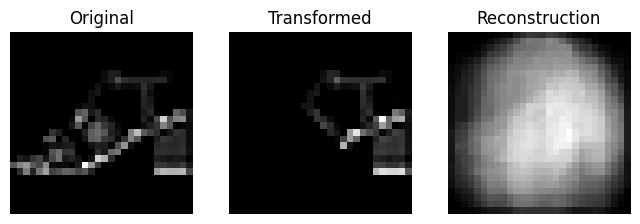

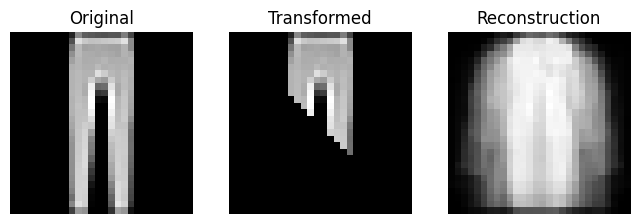

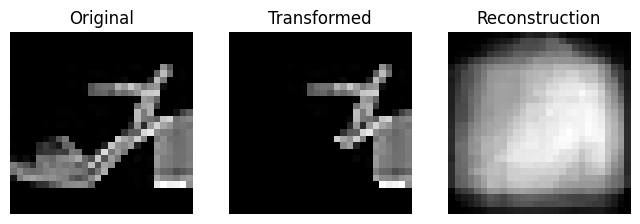

Beta: 0.2


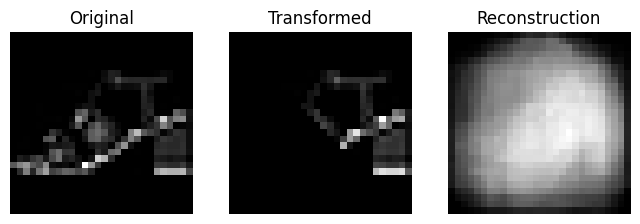

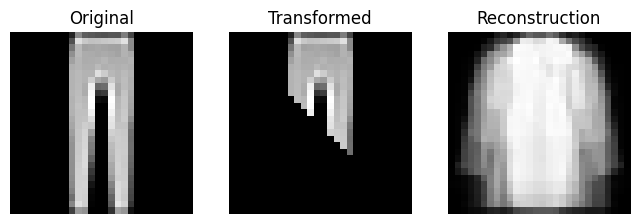

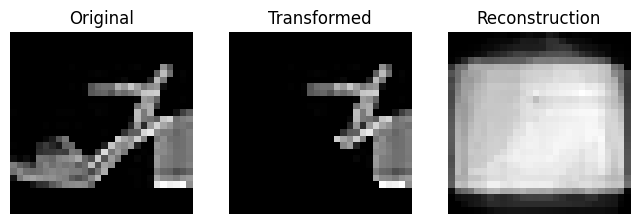

Beta: 0.5


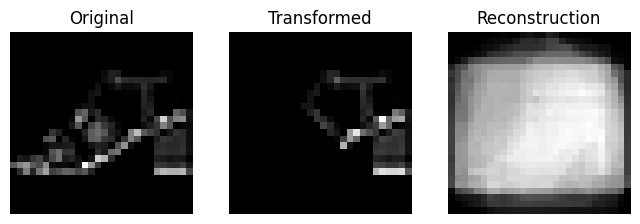

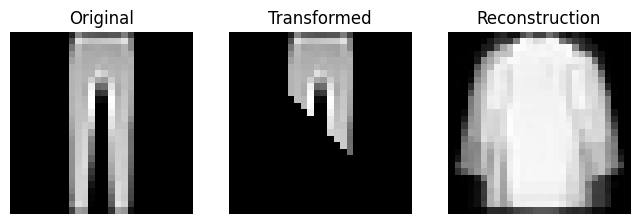

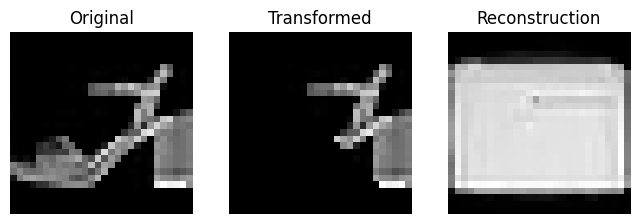

Beta: 1


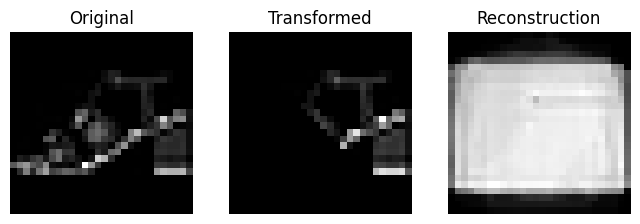

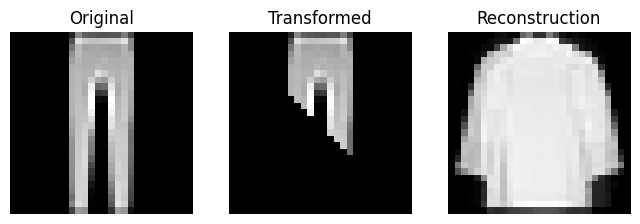

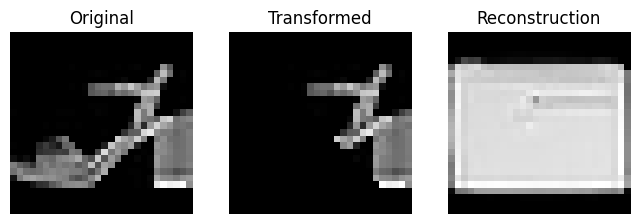

Beta: 2


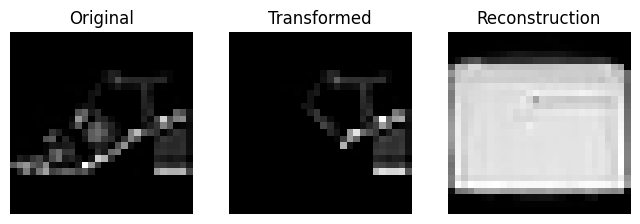

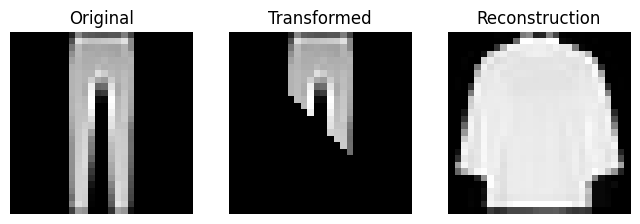

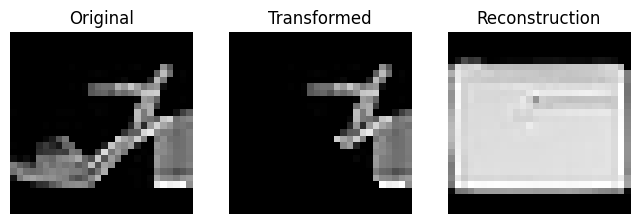

Beta: 4


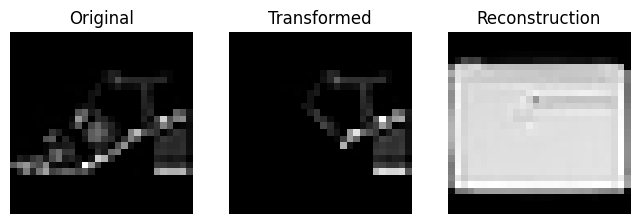

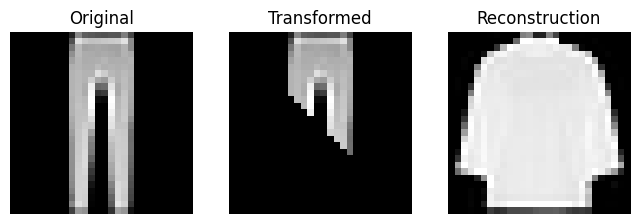

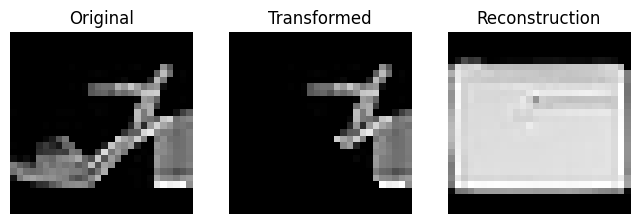

Beta: 8


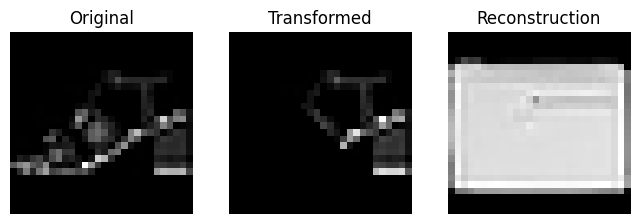

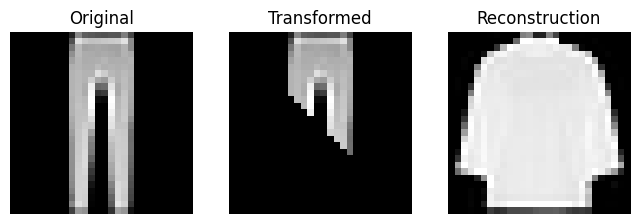

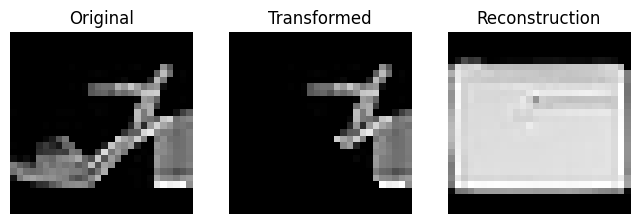

In [18]:
hopfield = HopfieldNetwork(binary=False)

betas = [0.1, 0.2, 0.5, 1, 2, 4, 8]
for beta in betas:
    print(f"Beta: {beta}")
    hopfield.retrieve_store(imgs, 100, transform_func=lambda im: transformer.mask_image(im, "diagonal_sym"), num_plot=3, break_val=3, beta=beta)